In [1]:
import copy
import importlib
import os
import warnings
from itertools import product

import torch
from dotenv import load_dotenv
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner
from tqdm.auto import tqdm

load_dotenv("../env")

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [20]:
import luminar.document.data
import luminar.document.model
import luminar.features
import luminar.mongo

importlib.reload(luminar.document.data)
importlib.reload(luminar.document.model)
importlib.reload(luminar.features)
importlib.reload(luminar.mongo)

<module 'luminar.mongo' from '/nvme/projects/PrismAI/PrismAI/src/luminar/mongo.py'>

In [21]:
from luminar.document.data import (
    DocumentClassificationDataModule,
    FeatureDataset,
    PaddingDataloader,
    n_way_split,
)
from luminar.document.model import ConvolutionalLayerSpec, DocumentClassficationModel
from luminar.features import FeatureExtractor, OneDimFeatures, Slicer, TwoDimFeatures
from luminar.mongo import MongoDatset

In [4]:
domains = {
    "Blog Authorship": {"domain": "blog_authorship_corpus"},
    "Student Essays": {"domain": "student_essays"},
    "CNN News": {"domain": "cnn_news"},
    "Euro Court Cases": {"domain": "euro_court_cases"},
    "House of Commons": {"domain": "house_of_commons"},
    "ArXiv Papers": {"domain": "arxiv_papers"},
    "Gutenberg": {"domain": "gutenberg"},
    "Bundestag [DE]": {"domain": "bundestag"},
    "Spiegel [DE]": {"domain": "spiegel_articles"},
    # "Gutenberg [DE]": {"domain": "gutenberg", "lang": "de-DE"},
}

In [5]:
dmap = {
    "Blog Authorship": "Blog Authorship",
    "Student Essays": "Student Essays",
    "CNN News": "CNN News",
    "Euro Court Cases": "Euro Court Cases",
    "House of Commons": "House of Commons",
    "ArXiv Papers": "ArXiv Papers",
    "Gutenberg [EN]": "Gutenberg",
    "Bundestag": "Bundestag [DE]",
    "Spiegel": "Spiegel [DE]",
    # "Gutenberg [DE]": 
}

In [6]:
config = {
    "seed": 1337,
    "eval_split": 0.1,
    "test_split": 0.1,
    "feature_model": "gpt2",
    "synth_agent": "gpt-4o-mini",
    # "synth_agent": "gemma2:9b"
}

In [7]:
datasets = {
    domain: MongoDatset(
        mongo_db_connection=os.environ.get("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_prismai",
        feature_model=config["feature_model"],
        synth_agent=config["synth_agent"],
        **kwargs,
    )
    for domain, kwargs in domains.items()
}

In [8]:
train_splits = {}
eval_splits = {}
test_splits = {}
for domain, dataset in datasets.items():
    seed_everything(config["seed"])
    train_dataset, eval_dataset, test_dataset = n_way_split(
        dataset,
        config["eval_split"],
        config["test_split"],
        infer_first=True,
    )
    train_splits[domain] = train_dataset
    eval_splits[domain] = eval_dataset
    test_splits[domain] = test_dataset

Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/6fe5c1ea3a4633ec60bc87ebc52f02e24546eacc75d014ff3870a788a6f42df1.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/22674c066cbcb55bcf2d3f2d5feadd616caceeb82e256620961dada261b75dcc.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/bbdde01b89676a5f2c4d82cf43d1b5f7071cec218f519be16dd1dfebdeacb7ac.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/c6cb0dc5d141e419441eceba902218f2128f377fe836cece3d6450a9992ce3e6.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/c1e288d51f532bf525959cfd500ceeb1d597c7539a1dea46216a82f32e9c6353.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/3a8b18d691e7c533e8deba53358a2472ce47ca53d830044e567890e398928f08.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/90fea92552034a8b51a3ce69f83ff4af1a196e4a651c4d326f65107b7ceb50d7.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/0f844027ef471bc1603bade40612188bd1e68f7d20617673a9d8db56f72dc5e4.pkl


Seed set to 1337


[MongoDatset] Loading Data from Cache File /tmp/luminar/72e65d4ab74e195872a70c33cf8861a888202e4cdac7fe412178b5b56b3385b8.pkl


In [9]:
# feature_dim = OneDimFeatures(256)
# featurizer = FeatureExtractor.Likelihood()
# featurizer = FeatureExtractor.LogLikelihoodLogRankRatio()
# config["second_dim_as_channels"] = False
feature_dim = TwoDimFeatures(256, 13)
# featurizer = FeatureExtractor.LikelihoodTopkLikelihoodRatio(13)
featurizer = FeatureExtractor.IntermediateLogits(13)
config["second_dim_as_channels"] = True

# slicer = Slicer.Random(feature_dim[0])
slicer = Slicer.RandomMultiple(feature_dim[0] // 4, multiple=4, stride=16)
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, 4)

config["feature_dim"] = feature_dim
config["featurizer"] = repr(featurizer)
config["slicer"] = repr(slicer)

config["num_samples"] = None


def featurize(dataset) -> FeatureDataset:
    return FeatureDataset(
        dataset, slicer, featurizer, num_samples=config["num_samples"]
    )

In [10]:
train_datasets, eval_datasets, test_datasets = {}, {}, {}
for domain, dataset in tqdm(datasets.items()):
    train_datasets[domain] = featurize(train_splits[domain])
    eval_datasets[domain] = featurize(eval_splits[domain])
    test_datasets[domain] = featurize(test_splits[domain])

  0%|          | 0/9 [00:00<?, ?it/s]

## In-Domain Training & Evaluation

In [11]:
config |= {
    "projection_dim": None,
    "learning_rate": 0.0001,
    "warmup_steps": 66,
    "max_epochs": 50,
    "gradient_clip_val": 0.5,
    "batch_size": 32,
}

# SeqXGPT Layer Configuration
config["conv_layer_shapes"] = [
    ConvolutionalLayerSpec(64, 5),
    *[ConvolutionalLayerSpec(128, 3)] * 3,
    ConvolutionalLayerSpec(64, 3),
]

In [12]:
from torch.utils.data import ConcatDataset


# capturing config from "closure"
def get_dataloader(*dataset, **kwargs) -> PaddingDataloader:
    if len(dataset) == 1:
        dataset = dataset[0]
    else:
        dataset = ConcatDataset(dataset)
    return PaddingDataloader(
        dataset,
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
        **kwargs,
    )

In [ ]:
results_in_domain = {}
for domain in domains:
    seed_everything(config["seed"])

    train_dataloader = get_dataloader(train_datasets[domain], shuffle=True)
    eval_dataloader = get_dataloader(eval_datasets[domain])

    model = DocumentClassficationModel(**config)
    trainer = Trainer(
        max_epochs=config["max_epochs"],
        logger=pl_loggers.TensorBoardLogger(
            save_dir=f"logs/in_domain/{type(featurizer).__name__}",
            name=domain,
        ),
        gradient_clip_val=config["gradient_clip_val"],
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
        deterministic=True,
    )

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=eval_dataloader,
    )

    trainer.progress_bar_callback.disable()
    metrics = []
    for other, dataset in test_datasets.items():
        trainer.validate(model, get_dataloader(eval_datasets[other]), verbose=False)
        metrics.append(
            {
                "other": other,
            }
            | trainer.test(
                model,
                get_dataloader(dataset),
                verbose=False,
            )[0]
        )
    trainer.progress_bar_callback.enable()

    results_in_domain[domain] = {
        "domain": domain,
        "config": copy.deepcopy(config),
        "metrics": metrics,
    }
    print(domain, metrics)


Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Blog Authorship [{'other': 'Blog Authorship', 'test_loss': 0.12927396595478058, 'test_acc@0.5': 0.9540635943412781, 'test_roc_auc': 0.9905263185501099, 'test_acc': 0.9540635943412781}, {'other': 'Student Essays', 'test_loss': 1.524064064025879, 'test_acc@0.5': 0.5600000023841858, 'test_roc_auc': 0.6703110933303833, 'test_acc': 0.5666666626930237}, {'other': 'CNN News', 'test_loss': 1.4044389724731445, 'test_acc@0.5': 0.5133333206176758, 'test_roc_auc': 0.7703555822372437, 'test_acc': 0.5299999713897705}, {'other': 'Euro Court Cases', 'test_loss': 2.6178324222564697, 'test_acc@0.5': 0.503333330154419, 'test_roc_auc': 0.7273111343383789, 'test_acc': 0.503333330154419}, {'other': 'House of Commons', 'test_loss': 1.8245090246200562, 'test_acc@0.5': 0.5033556818962097, 'test_roc_auc': 0.6809459328651428, 'test_acc': 0.5100671052932739}, {'other': 'ArXiv Papers', 'test_loss': 1.4874645471572876, 'test_acc@0.5': 0.5017064809799194, 'test_roc_auc': 0.8186562061309814, 'test_acc': 0.52218431234

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Student Essays [{'other': 'Blog Authorship', 'test_loss': 6.6242289543151855, 'test_acc@0.5': 0.6007066965103149, 'test_roc_auc': 0.5453634262084961, 'test_acc': 0.5795053243637085}, {'other': 'Student Essays', 'test_loss': 0.16484086215496063, 'test_acc@0.5': 0.9133333563804626, 'test_roc_auc': 0.9873777627944946, 'test_acc': 0.949999988079071}, {'other': 'CNN News', 'test_loss': 1.0666855573654175, 'test_acc@0.5': 0.7266666889190674, 'test_roc_auc': 0.8714222311973572, 'test_acc': 0.7633333206176758}, {'other': 'Euro Court Cases', 'test_loss': 1.1247600317001343, 'test_acc@0.5': 0.6966666579246521, 'test_roc_auc': 0.8642666935920715, 'test_acc': 0.7633333206176758}, {'other': 'House of Commons', 'test_loss': 1.9349571466445923, 'test_acc@0.5': 0.7651006579399109, 'test_roc_auc': 0.7896396517753601, 'test_acc': 0.7885906100273132}, {'other': 'ArXiv Papers', 'test_loss': 1.8645610809326172, 'test_acc@0.5': 0.7576791644096375, 'test_roc_auc': 0.7656322717666626, 'test_acc': 0.7610921263

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


CNN News [{'other': 'Blog Authorship', 'test_loss': 2.6755316257476807, 'test_acc@0.5': 0.5194346308708191, 'test_roc_auc': 0.24295739829540253, 'test_acc': 0.5229681730270386}, {'other': 'Student Essays', 'test_loss': 1.0468742847442627, 'test_acc@0.5': 0.7099999785423279, 'test_roc_auc': 0.7954666614532471, 'test_acc': 0.7099999785423279}, {'other': 'CNN News', 'test_loss': 0.20822416245937347, 'test_acc@0.5': 0.9133333563804626, 'test_roc_auc': 0.9815999865531921, 'test_acc': 0.9433333277702332}, {'other': 'Euro Court Cases', 'test_loss': 0.37343406677246094, 'test_acc@0.5': 0.8500000238418579, 'test_roc_auc': 0.9469777941703796, 'test_acc': 0.8933333158493042}, {'other': 'House of Commons', 'test_loss': 0.6511669158935547, 'test_acc@0.5': 0.8456375598907471, 'test_roc_auc': 0.846486508846283, 'test_acc': 0.8557047247886658}, {'other': 'ArXiv Papers', 'test_loss': 0.7939708828926086, 'test_acc@0.5': 0.8054607510566711, 'test_roc_auc': 0.8560246229171753, 'test_acc': 0.83617746829986

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Euro Court Cases [{'other': 'Blog Authorship', 'test_loss': 3.750967264175415, 'test_acc@0.5': 0.46289753913879395, 'test_roc_auc': 0.26654136180877686, 'test_acc': 0.40282684564590454}, {'other': 'Student Essays', 'test_loss': 1.239440679550171, 'test_acc@0.5': 0.75, 'test_roc_auc': 0.8228444457054138, 'test_acc': 0.6933333277702332}, {'other': 'CNN News', 'test_loss': 0.4872305989265442, 'test_acc@0.5': 0.8533333539962769, 'test_roc_auc': 0.9318666458129883, 'test_acc': 0.8266666531562805}, {'other': 'Euro Court Cases', 'test_loss': 0.12037040293216705, 'test_acc@0.5': 0.95333331823349, 'test_roc_auc': 0.9942666888237, 'test_acc': 0.9633333086967468}, {'other': 'House of Commons', 'test_loss': 0.5555992126464844, 'test_acc@0.5': 0.8523489832878113, 'test_roc_auc': 0.9129729866981506, 'test_acc': 0.744966447353363}, {'other': 'ArXiv Papers', 'test_loss': 0.5808747410774231, 'test_acc@0.5': 0.8839590549468994, 'test_roc_auc': 0.9197651743888855, 'test_acc': 0.8361774682998657}, {'other

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


House of Commons [{'other': 'Blog Authorship', 'test_loss': 1.6250951290130615, 'test_acc@0.5': 0.4098939895629883, 'test_roc_auc': 0.4286716878414154, 'test_acc': 0.4416961073875427}, {'other': 'Student Essays', 'test_loss': 0.5336195826530457, 'test_acc@0.5': 0.8266666531562805, 'test_roc_auc': 0.9189333319664001, 'test_acc': 0.8366666436195374}, {'other': 'CNN News', 'test_loss': 0.5140358805656433, 'test_acc@0.5': 0.8066666722297668, 'test_roc_auc': 0.9035999774932861, 'test_acc': 0.8066666722297668}, {'other': 'Euro Court Cases', 'test_loss': 0.6002725958824158, 'test_acc@0.5': 0.8299999833106995, 'test_roc_auc': 0.9213777780532837, 'test_acc': 0.8066666722297668}, {'other': 'House of Commons', 'test_loss': 0.23081710934638977, 'test_acc@0.5': 0.9161073565483093, 'test_roc_auc': 0.9741891622543335, 'test_acc': 0.9228187799453735}, {'other': 'ArXiv Papers', 'test_loss': 0.3865963816642761, 'test_acc@0.5': 0.8976109027862549, 'test_roc_auc': 0.9358866810798645, 'test_acc': 0.8907849

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


ArXiv Papers [{'other': 'Blog Authorship', 'test_loss': 3.663987159729004, 'test_acc@0.5': 0.5017668008804321, 'test_roc_auc': 0.5705012679100037, 'test_acc': 0.5017668008804321}, {'other': 'Student Essays', 'test_loss': 0.6074722409248352, 'test_acc@0.5': 0.800000011920929, 'test_roc_auc': 0.8910222053527832, 'test_acc': 0.8100000023841858}, {'other': 'CNN News', 'test_loss': 0.47591787576675415, 'test_acc@0.5': 0.8100000023841858, 'test_roc_auc': 0.8979555368423462, 'test_acc': 0.8266666531562805}, {'other': 'Euro Court Cases', 'test_loss': 0.6954304575920105, 'test_acc@0.5': 0.7599999904632568, 'test_roc_auc': 0.9099110960960388, 'test_acc': 0.7433333396911621}, {'other': 'House of Commons', 'test_loss': 0.6852285265922546, 'test_acc@0.5': 0.8389261960983276, 'test_roc_auc': 0.8872522711753845, 'test_acc': 0.8557047247886658}, {'other': 'ArXiv Papers', 'test_loss': 0.1830557882785797, 'test_acc@0.5': 0.9317406415939331, 'test_roc_auc': 0.9794986248016357, 'test_acc': 0.9215016961097

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Gutenberg [{'other': 'Blog Authorship', 'test_loss': 1.7988485097885132, 'test_acc@0.5': 0.4840989410877228, 'test_roc_auc': 0.36812031269073486, 'test_acc': 0.5123674869537354}, {'other': 'Student Essays', 'test_loss': 0.6884621381759644, 'test_acc@0.5': 0.7233333587646484, 'test_roc_auc': 0.893822193145752, 'test_acc': 0.7933333516120911}, {'other': 'CNN News', 'test_loss': 0.53090500831604, 'test_acc@0.5': 0.7900000214576721, 'test_roc_auc': 0.861822247505188, 'test_acc': 0.7266666889190674}, {'other': 'Euro Court Cases', 'test_loss': 1.000800371170044, 'test_acc@0.5': 0.6299999952316284, 'test_roc_auc': 0.8449777960777283, 'test_acc': 0.5433333516120911}, {'other': 'House of Commons', 'test_loss': 0.35946178436279297, 'test_acc@0.5': 0.8255033493041992, 'test_roc_auc': 0.9254504442214966, 'test_acc': 0.7785235047340393}, {'other': 'ArXiv Papers', 'test_loss': 0.3020920753479004, 'test_acc@0.5': 0.8703071475028992, 'test_roc_auc': 0.9440406560897827, 'test_acc': 0.8430033922195435},

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Bundestag [DE] [{'other': 'Blog Authorship', 'test_loss': 7.39722204208374, 'test_acc@0.5': 0.16961130499839783, 'test_roc_auc': 0.19576440751552582, 'test_acc': 0.18727914988994598}, {'other': 'Student Essays', 'test_loss': 8.450758934020996, 'test_acc@0.5': 0.5299999713897705, 'test_roc_auc': 0.6588444709777832, 'test_acc': 0.5266666412353516}, {'other': 'CNN News', 'test_loss': 5.898632049560547, 'test_acc@0.5': 0.5299999713897705, 'test_roc_auc': 0.81086665391922, 'test_acc': 0.5266666412353516}, {'other': 'Euro Court Cases', 'test_loss': 11.601397514343262, 'test_acc@0.5': 0.49000000953674316, 'test_roc_auc': 0.5934666395187378, 'test_acc': 0.49000000953674316}, {'other': 'House of Commons', 'test_loss': 5.868144512176514, 'test_acc@0.5': 0.47651007771492004, 'test_roc_auc': 0.6883333325386047, 'test_acc': 0.47651007771492004}, {'other': 'ArXiv Papers', 'test_loss': 5.0874199867248535, 'test_acc@0.5': 0.4948805570602417, 'test_roc_auc': 0.7518637776374817, 'test_acc': 0.4914675652

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Se

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Spiegel [DE] [{'other': 'Blog Authorship', 'test_loss': 1.899004578590393, 'test_acc@0.5': 0.5300353169441223, 'test_roc_auc': 0.3709774315357208, 'test_acc': 0.5300353169441223}, {'other': 'Student Essays', 'test_loss': 1.9004229307174683, 'test_acc@0.5': 0.6133333444595337, 'test_roc_auc': 0.6586666703224182, 'test_acc': 0.6133333444595337}, {'other': 'CNN News', 'test_loss': 1.2783634662628174, 'test_acc@0.5': 0.6633333563804626, 'test_roc_auc': 0.740066647529602, 'test_acc': 0.6633333563804626}, {'other': 'Euro Court Cases', 'test_loss': 1.8682434558868408, 'test_acc@0.5': 0.6033333539962769, 'test_roc_auc': 0.7562888860702515, 'test_acc': 0.6000000238418579}, {'other': 'House of Commons', 'test_loss': 1.1434385776519775, 'test_acc@0.5': 0.6677852272987366, 'test_roc_auc': 0.7288288474082947, 'test_acc': 0.6677852272987366}, {'other': 'ArXiv Papers', 'test_loss': 0.9927137494087219, 'test_acc@0.5': 0.7337883710861206, 'test_roc_auc': 0.7872052788734436, 'test_acc': 0.72696244716644

In [23]:
import pandas as pd

results = []
for domain in domains:
    results.append(
        [results_in_domain[domain]["metrics"][i]["test_roc_auc"] for i in range(len(domains))]
    )

df = pd.DataFrame(results, columns=domains, index=domains)
df

,Blog Authorship,Student Essays,CNN News,Euro Court Cases,House of Commons,ArXiv Papers,Gutenberg,Bundestag [DE],Spiegel [DE]
Blog Authorship,0.990526,0.670311,0.770356,0.727311,0.680946,0.818656,0.830402,0.585027,0.671365
Student Essays,0.545363,0.987378,0.871422,0.864267,0.789640,0.765632,0.874610,0.712686,0.776286
CNN News,0.242957,0.795467,0.981600,0.946978,0.846487,0.856025,0.904823,0.728708,0.656823
Euro Court Cases,0.266541,0.822844,0.931867,0.994267,0.912973,0.919765,0.871915,0.569288,0.500940
House of Commons,0.428672,0.918933,0.903600,0.921378,0.974189,0.935887,0.882033,0.713489,0.653870
ArXiv Papers,0.570501,0.891022,0.897956,0.909911,0.887252,0.979499,0.911111,0.603696,0.497852
Gutenberg,0.368120,0.893822,0.861822,0.844978,0.925450,0.944041,0.977116,0.718074,0.716868
Bundestag [DE],0.195764,0.658844,0.810867,0.593467,0.688333,0.751864,0.787612,0.954627,0.927696
Spiegel [DE],0.370977,0.658667,0.740067,0.756289,0.728829,0.787205,0.687092,0.892476,0.953468


## Cross-Domain Training & Evaluation

In [24]:
seed_everything(config["seed"])
train_dataloader = get_dataloader(*train_datasets.values(), shuffle=True)
eval_dataloader = get_dataloader(*eval_datasets.values())
test_dataloader = get_dataloader(*test_datasets.values())

model = DocumentClassficationModel(**config)
trainer = Trainer(
    max_epochs=config["max_epochs"],
    logger=pl_loggers.TensorBoardLogger(
        save_dir=f"logs/all_domains/{type(featurizer).__name__}",
    ),
    gradient_clip_val=config["gradient_clip_val"],
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
    deterministic=True,
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=eval_dataloader,
)

Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [25]:
trainer.progress_bar_callback.disable()
metrics_cross_domain = []
for other, dataset in test_datasets.items():
    trainer.validate(model, get_dataloader(eval_datasets[domain]), verbose=False)
    metrics_cross_domain.append(
        {"other": other}
        | trainer.test(
            model,
            get_dataloader(dataset),
            verbose=False,
        )[0]
    )
trainer.validate(model, eval_dataloader, verbose=False)
metrics_cross_domain += [
    {
        "other": "ALL",
        **trainer.test(
            model,
            test_dataloader,
            verbose=False,
        )[0],
    }
]
trainer.progress_bar_callback.enable()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [26]:
import pandas as pd


def df_to_latex_heatmap(_df: pd.DataFrame):
    print(
        "\\plotHeatmap{"
        + ",".join(_df.index)
        + "}{%\n    "
        + ",%\n    ".join(
            [
                "{"
                + ",".join(f"{val:.4f}/{round(val, 2):.2f}" for val in row[1:])
                + "}"
                for row in _df.reset_index().values
            ]
        )
        + "%\n}{"
        + ",".join(_df.columns)
        + "}"
    )


In [83]:
# _metric = "test_roc_auc"
_metric = "test_acc"

results = []
for domain in domains:
    results.append(
        [
            results_in_domain[domain]["metrics"][i][_metric]
            for i in range(len(domains))
        ]
    )
results.append([m[_metric] for m in metrics_cross_domain[:len(domains)]])

df = pd.DataFrame(results, columns=domains, index=list(domains) + ["ALL"])
df["AVG"] = df.mean(axis=1)
df["AVG"][-1] = metrics_cross_domain[-1][_metric]
df

/tmp/ipykernel_1250882/1315127472.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["AVG"][-1] = metrics_cross_domain[-1][_metric]
/tmp/ipykernel_1250882/1315127472.py:16: FutureWarning: Series.__setitem__ treating keys as positions is

,Blog Authorship,Student Essays,CNN News,Euro Court Cases,House of Commons,ArXiv Papers,Gutenberg,Bundestag [DE],Spiegel [DE],AVG
Blog Authorship,0.954064,0.566667,0.530000,0.503333,0.510067,0.522184,0.556701,0.597938,0.642140,0.598122
Student Essays,0.579505,0.950000,0.763333,0.763333,0.788591,0.761092,0.831615,0.491409,0.508361,0.715249
CNN News,0.522968,0.710000,0.943333,0.893333,0.855705,0.836177,0.835052,0.487972,0.508361,0.732545
Euro Court Cases,0.402827,0.693333,0.826667,0.963333,0.744966,0.836177,0.780069,0.491409,0.501672,0.693384
House of Commons,0.441696,0.836667,0.806667,0.806667,0.922819,0.890785,0.797251,0.491409,0.501672,0.721737
ArXiv Papers,0.501767,0.810000,0.826667,0.743333,0.855705,0.921502,0.838488,0.487972,0.491639,0.719675
Gutenberg,0.512367,0.793333,0.726667,0.543333,0.778524,0.843003,0.927835,0.522337,0.528428,0.686203
Bundestag [DE],0.187279,0.526667,0.526667,0.490000,0.476510,0.491468,0.501718,0.890034,0.866221,0.550729
Spiegel [DE],0.530035,0.613333,0.663333,0.600000,0.667785,0.726962,0.639175,0.790378,0.879599,0.678956
ALL,0.943463,0.806667,0.923333,0.940000,0.929530,0.959044,0.945017,0.862543,0.826087,0.911111


In [84]:
df_to_latex_heatmap(df)

\plotHeatmap{Blog Authorship,Student Essays,CNN News,Euro Court Cases,House of Commons,ArXiv Papers,Gutenberg,Bundestag [DE],Spiegel [DE],ALL}{%
    {0.9541/0.95,0.5667/0.57,0.5300/0.53,0.5033/0.50,0.5101/0.51,0.5222/0.52,0.5567/0.56,0.5979/0.60,0.6421/0.64,0.5981/0.60},%
    {0.5795/0.58,0.9500/0.95,0.7633/0.76,0.7633/0.76,0.7886/0.79,0.7611/0.76,0.8316/0.83,0.4914/0.49,0.5084/0.51,0.7152/0.72},%
    {0.5230/0.52,0.7100/0.71,0.9433/0.94,0.8933/0.89,0.8557/0.86,0.8362/0.84,0.8351/0.84,0.4880/0.49,0.5084/0.51,0.7325/0.73},%
    {0.4028/0.40,0.6933/0.69,0.8267/0.83,0.9633/0.96,0.7450/0.74,0.8362/0.84,0.7801/0.78,0.4914/0.49,0.5017/0.50,0.6934/0.69},%
    {0.4417/0.44,0.8367/0.84,0.8067/0.81,0.8067/0.81,0.9228/0.92,0.8908/0.89,0.7973/0.80,0.4914/0.49,0.5017/0.50,0.7217/0.72},%
    {0.5018/0.50,0.8100/0.81,0.8267/0.83,0.7433/0.74,0.8557/0.86,0.9215/0.92,0.8385/0.84,0.4880/0.49,0.4916/0.49,0.7197/0.72},%
    {0.5124/0.51,0.7933/0.79,0.7267/0.73,0.5433/0.54,0.7785/0.78,0.8430/0.84,0.9278/0.9

In [85]:
config

{'seed': 1337,
 'eval_split': 0.1,
 'test_split': 0.1,
 'feature_model': 'gpt2',
 'synth_agent': 'gpt-4o-mini',
 'second_dim_as_channels': True,
 'feature_dim': TwoDimFeatures(height=256, width=13),
 'featurizer': 'IntermediateLogits(last_n=13)',
 'slicer': 'SliceRandomMultiple(size=64, multiple=4, stride=16, sort=False)',
 'num_samples': None,
 'projection_dim': None,
 'learning_rate': 0.0001,
 'warmup_steps': 66,
 'max_epochs': 50,
 'gradient_clip_val': 0.5,
 'batch_size': 32,
 'conv_layer_shapes': [(64, 5, 1),
  (128, 3, 1),
  (128, 3, 1),
  (128, 3, 1),
  (64, 3, 1)]}

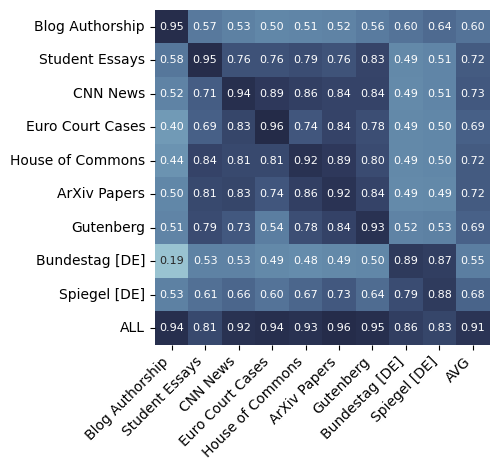

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True),
    yticklabels=list(domains) + ["ALL"],
    xticklabels=list(domains) + ["AVG"],
    square=True,
    # reduce annotation font size
    annot_kws={"fontsize": 8},
    cbar=False,
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

plt.tight_layout()
# plt.savefig(
#     "../figures/evaluation-trained_in_domain-test_0.1-gpt2_256-rand_4-il_13_as_channels.pdf",
#     dpi=300,
# )
plt.show()

### LLR on Whole Datasets

In [90]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

results_llr = []
for domain, split in datasets.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["type"] != "source"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    auroc = auc(fpr, tpr)

    preds = np.array(dataset_test["llr"])
    labels = np.array(dataset_test["labels"])

    mean_0 = float(np.mean(preds[labels == 0]))
    mean_1 = float(np.mean(preds[labels == 1]))

    thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 5001)
    preds_thresholded: np.ndarray = preds > thresholds.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    best_threshold = thresholds[idx]
    best_acc = acc_thresholded[idx]

    results_llr.append({
        "domain": domain,
        "auroc": auroc,
        "best_acc": best_acc,
        "best_threshold": best_threshold,
    })

pd.DataFrame(results_llr)

,domain,auroc,best_acc,best_threshold
0,Blog Authorship,0.469396,0.530336,1.91608
1,Student Essays,0.845398,0.780333,1.97588
2,CNN News,0.941183,0.879000,1.99316
3,Euro Court Cases,0.914577,0.855092,2.05116
4,House of Commons,0.855806,0.852013,1.98152
5,ArXiv Papers,0.965488,0.940333,1.90800
6,Gutenberg,0.902650,0.845036,1.92608
7,Bundestag [DE],0.843577,0.783276,1.79000
8,Spiegel [DE],0.866562,0.812083,1.75800


### LLR on Test Splits

In [91]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

results_llr = []
for domain, split in test_splits.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["type"] != "source"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    auroc = auc(fpr, tpr)

    preds = np.array(dataset_test["llr"])
    labels = np.array(dataset_test["labels"])

    mean_0 = float(np.mean(preds[labels == 0]))
    mean_1 = float(np.mean(preds[labels == 1]))

    thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 1001)
    preds_thresholded: np.ndarray = preds > thresholds.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    best_threshold = thresholds[idx]
    best_acc = acc_thresholded[idx]

    results_llr.append({
        "domain": domain,
        "auroc": auroc,
        "best_acc": best_acc,
        "best_threshold": best_threshold,
    })

pd.DataFrame(results_llr)

,domain,auroc,best_acc,best_threshold
0,Blog Authorship,0.442306,0.530035,1.9120
1,Student Essays,0.850044,0.790000,1.9748
2,CNN News,0.931244,0.880000,1.9800
3,Euro Court Cases,0.916222,0.856667,2.0730
4,House of Commons,0.853063,0.852349,1.9922
5,ArXiv Papers,0.953639,0.924915,1.9143
6,Gutenberg,0.886903,0.848797,1.9148
7,Bundestag [DE],0.818272,0.780069,1.7965
8,Spiegel [DE],0.858389,0.789298,1.7454


In [89]:
raise RuntimeError("STOP")

RuntimeError: STOP

In [ ]:
sample = train_datasets["CNN News"][0]["features"].numpy().squeeze()
train_datasets["CNN News"][0]["labels"]

In [ ]:
fig = plt.imshow(sample.T, cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True))
fig.axes.set_axis_off()
plt.show()

In [ ]:
sample = train_datasets["CNN News"][1]["features"].numpy().squeeze()
train_datasets["CNN News"][1]["labels"]

In [ ]:
fig = plt.imshow(sample.T, cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True))
fig.axes.set_axis_off()
plt.show()

In [ ]:
raise RuntimeError("STOP")

In [ ]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores

dataset_test = dm._dataset_test.map(
    lambda x: {
        "llr": llr_from_transition_scores(x["features"]),
        "labels": x["labels"],
    },
    in_place=False,
)
fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
auc(fpr, tpr)